In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from mytools import Video, get_cuts

2023-11-23 02:57:08.306686: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-23 02:57:08.344104: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 02:57:08.344146: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 02:57:08.344182: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-23 02:57:08.351095: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-23 02:57:08.351598: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# Load model

In [2]:
model_path = 'models'
model_files = np.array(os.listdir(model_path))
model_files = np.sort(model_files[np.char.find(model_files, '.h5') != -1])
model_path = os.path.join(model_path, model_files[-1])
print(f'We a going to upload model {model_path}')

We a going to upload model models/2023-11-22-17-24.h5


In [3]:
model = tf.keras.models.load_model(model_path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 2, 158, 88, 32)    2624      
                                                                 
 max_pooling3d (MaxPooling3  (None, 2, 79, 44, 32)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 1, 78, 43, 32)     8224      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 1, 39, 21, 32)     0         
 g3D)                                                            
                                                                 
 flatten (Flatten)           (None, 26208)             0         
                                                                 
 dense (Dense)               (None, 256)               6

In [4]:
input_size = tuple(model.input.shape[1:])
video_size = input_size[1], input_size[2]
print(f'Model input shape is {input_size}')
print(f'So video size should be {video_size}')

Model input shape is (4, 160, 90, 3)
So video size should be (160, 90)


# Analyzer

In [5]:
def predict_cuts(model, video: Video, fill=True, fill_value=0, fill_begin=2, fill_end=2):
    """
    Returns predicted cuts.
    
    Parameters:
    -----------
    model : keras model
    
    video : mytools.Video
    
    fill : bool
        Add values to the begin and end of result
    
    fill_value : int or bool
        Value, which will added to the begin and the end, if fill is True
        
    fill_begin : int
        Number of added values to begin
        
    fill_end : int
        Number of added values to end
    
    Returns:
    --------
    res : np.array
    """
    input_size = tuple(model.input.shape[1:])
    video_size = input_size[2], input_size[1]
    fragment_length = input_size[0]
    res = []
    
    pbar = tqdm(total=len(video) - fragment_length)
    # Make here loop of video fragments length 4 (fragment_length) and add predicted value every step
    for matrix in video.generate_matrices(matrix_length=fragment_length, new_size=video_size):
        X = matrix.reshape(np.append(1, matrix.shape))
        y = model(X)
        res.append(y)
        pbar.update()
    pbar.close()
    
    if fill:
        res = np.concatenate([np.ones(fill_begin)*fill_value, np.array(res)[:, 0, 0], np.ones(fill_end)*fill_value])
    return res

# Video 0

In [6]:
video = Video('videos/0.mp4')
cuts = get_cuts('timelines/0.kdenlive')

In [7]:
cuts_real = np.zeros(len(video))
cuts_real[cuts] = 1

In [8]:
cuts_predicted = predict_cuts(model, video)

  0%|          | 0/5871 [00:00<?, ?it/s]

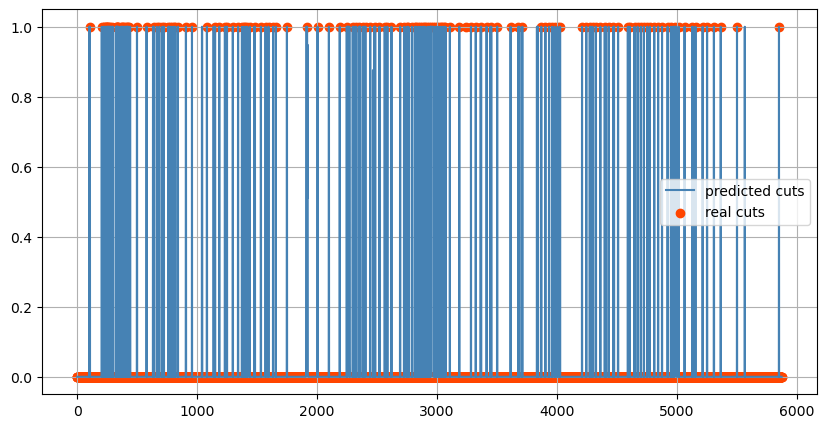

In [9]:
n = len(video)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n), cuts_predicted[:n], color='steelblue', label='predicted cuts')
plt.scatter(np.arange(n), cuts_real[:n], color='orangered', label='real cuts')
plt.grid(True)
plt.legend()
plt.show()

In [10]:
df_frame_info = pd.DataFrame({'real cut' : cuts_real == 1, 
                              'predicted cut' : cuts_predicted > 0.5})
df_frame_info[232:].head(20).transpose()

232    233    234    235    236   237    238    239    240  \
real cut       False  False  False  False  False  True  False  False  False   
predicted cut  False  False  False  False  False  True  False  False  False   

                 241    242    243   244    245    246    247    248    249  \
real cut       False  False  False  True  False  False  False  False   True   
predicted cut  False  False   True  True  False  False  False  False  False   

                 250    251  
real cut       False  False  
predicted cut  False  False

In [11]:
df_square = df_frame_info.copy()
df_square['value'] = df_square.index
df_square = df_square.groupby(['real cut', 'predicted cut'], as_index=False).count()
df_square = pd.DataFrame({'predicted noncut' : df_square[df_square['predicted cut'] == False]['value'].values, 
                          'predicted cut' : df_square[df_square['predicted cut'] == True]['value'].values}, 
                         index=['real noncut', 'real cut'])
print('There are {0} wrong cuts predicted and {1} wrong noncuts.'.format(df_square.loc['real noncut', 'predicted cut'], 
                                                                         df_square.loc['real cut', 'predicted noncut']))
df_square

There are 252 wrong cuts predicted and 7 wrong noncuts.


predicted noncut  predicted cut
real noncut              5472            252
real cut                    7            144

In [12]:
df_square_portion = df_square / df_square.values.sum()
print('There are {0:.2f}% wrong cuts predicted and {1:.2f}% wrong noncuts.'.format(100*float(df_square_portion.loc['real noncut', 'predicted cut']), 
                                                                                  100*float(df_square_portion.loc['real cut', 'predicted noncut'])))
print('But the real cuts portion is just {0:.2f}%'.format(100*float(df_square_portion.loc['real cut', 'predicted cut'])))
df_square_portion

There are 4.29% wrong cuts predicted and 0.12% wrong noncuts.
But the real cuts portion is just 2.45%


predicted noncut  predicted cut
real noncut          0.931404       0.042894
real cut             0.001191       0.024511

/tmp/ipykernel_10321/1528520417.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


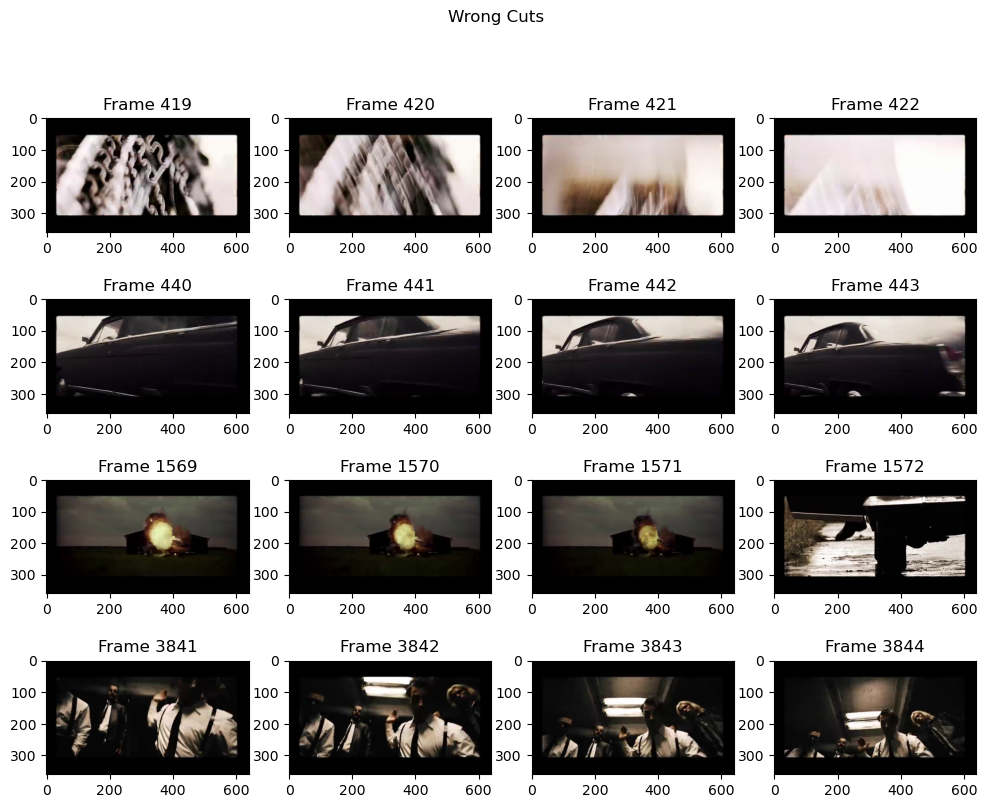

In [13]:
wrong_cuts = df_frame_info[(df_frame_info['real cut'] == False)&(df_frame_info['predicted cut'] == True)].index.values
chosen_wrong_cuts = np.sort(np.random.choice(wrong_cuts, 4, replace=False))


fig, axs = plt.subplots(4, 4)

fig.set_figheight(9)
fig.set_figwidth(12)
fig.suptitle('Wrong Cuts')

for i in range(4):
    for k in range(4):
        idx = chosen_wrong_cuts[i] - 2 + k
        frame = video.get_frame(idx)
        axs[i, k].set_title(f'Frame {idx}')
        axs[i, k].imshow(frame)
fig.show()

In [14]:
wrong_noncuts = df_frame_info[(df_frame_info['real cut'] == True)&(df_frame_info['predicted cut'] == False)].index.values
chosen_wrong_noncuts = np.sort(np.random.choice(wrong_noncuts, 4, replace=False))


fig, axs = plt.subplots(4, 4)

fig.set_figheight(9)
fig.set_figwidth(12)
fig.suptitle('Wrong Noncuts')

for i in range(4):
    for k in range(4):
        idx = chosen_wrong_noncuts[i] - 2 + k
        frame = video.get_frame(idx)
        axs[i, k].set_title(f'Frame {idx}')
        axs[i, k].imshow(frame)
fig.show()

/tmp/ipykernel_10321/4132339254.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


# Video 1

In [15]:
video = Video('videos/1.mp4')
cuts = get_cuts('timelines/1.kdenlive')

In [16]:
cuts_real = np.zeros(len(video))
cuts_real[cuts] = 1

In [17]:
cuts_predicted = predict_cuts(model, video)

  0%|          | 0/5746 [00:00<?, ?it/s]

In [18]:
n = len(video)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n), cuts_predicted[:n], color='steelblue', label='predicted cuts')
plt.scatter(np.arange(n), cuts_real[:n], color='orangered', label='real cuts')
plt.grid(True)
plt.legend()
plt.show()

In [19]:
df_frame_info = pd.DataFrame({'real cut' : cuts_real == 1, 
                              'predicted cut' : cuts_predicted > 0.5})
df_frame_info[321:].head(20).transpose()

321    322    323    324    325    326    327    328    329  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 330    331    332    333    334    335    336    337    338  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 339    340  
real cut       False  False  
predicted cut  False  False

In [20]:
df_square = df_frame_info.copy()
df_square['value'] = df_square.index
df_square = df_square.groupby(['real cut', 'predicted cut'], as_index=False).count()
df_square = pd.DataFrame({'predicted noncut' : df_square[df_square['predicted cut'] == False]['value'].values, 
                          'predicted cut' : df_square[df_square['predicted cut'] == True]['value'].values}, 
                         index=['real noncut', 'real cut'])
print('There are {0} wrong cuts predicted and {1} wrong noncuts.'.format(df_square.loc['real noncut', 'predicted cut'], 
                                                                         df_square.loc['real cut', 'predicted noncut']))
df_square

There are 637 wrong cuts predicted and 17 wrong noncuts.


predicted noncut  predicted cut
real noncut              4873            637
real cut                   17            223

In [21]:
df_square_portion = df_square / df_square.values.sum()
print('There are {0:.2f}% wrong cuts predicted and {1:.2f}% wrong noncuts.'.format(100*float(df_square_portion.loc['real noncut', 'predicted cut']), 
                                                                                  100*float(df_square_portion.loc['real cut', 'predicted noncut'])))
print('But the real cuts portion is just {0:.2f}%'.format(100*float(df_square_portion.loc['real cut', 'predicted cut'])))
df_square_portion

There are 11.08% wrong cuts predicted and 0.30% wrong noncuts.
But the real cuts portion is just 3.88%


predicted noncut  predicted cut
real noncut          0.847478       0.110783
real cut             0.002957       0.038783

/tmp/ipykernel_10321/1817327170.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


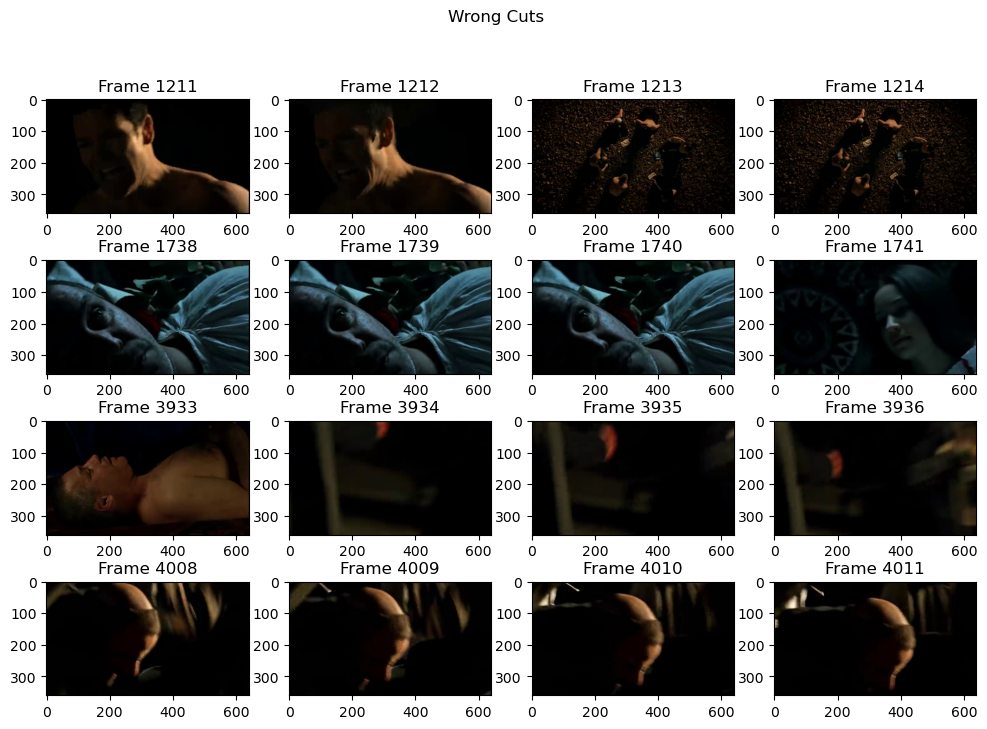

In [22]:
wrong_cuts = df_frame_info[(df_frame_info['real cut'] == False)&(df_frame_info['predicted cut'] == True)].index.values
chosen_wrong_cuts = np.sort(np.random.choice(wrong_cuts, 4, replace=False))


fig, axs = plt.subplots(4, 4)

fig.set_figheight(8)
fig.set_figwidth(12)
fig.suptitle('Wrong Cuts')

for i in range(4):
    for k in range(4):
        idx = chosen_wrong_cuts[i] - 2 + k
        frame = video.get_frame(idx)
        axs[i, k].set_title(f'Frame {idx}')
        axs[i, k].imshow(frame)
fig.show()

/tmp/ipykernel_10321/4132339254.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


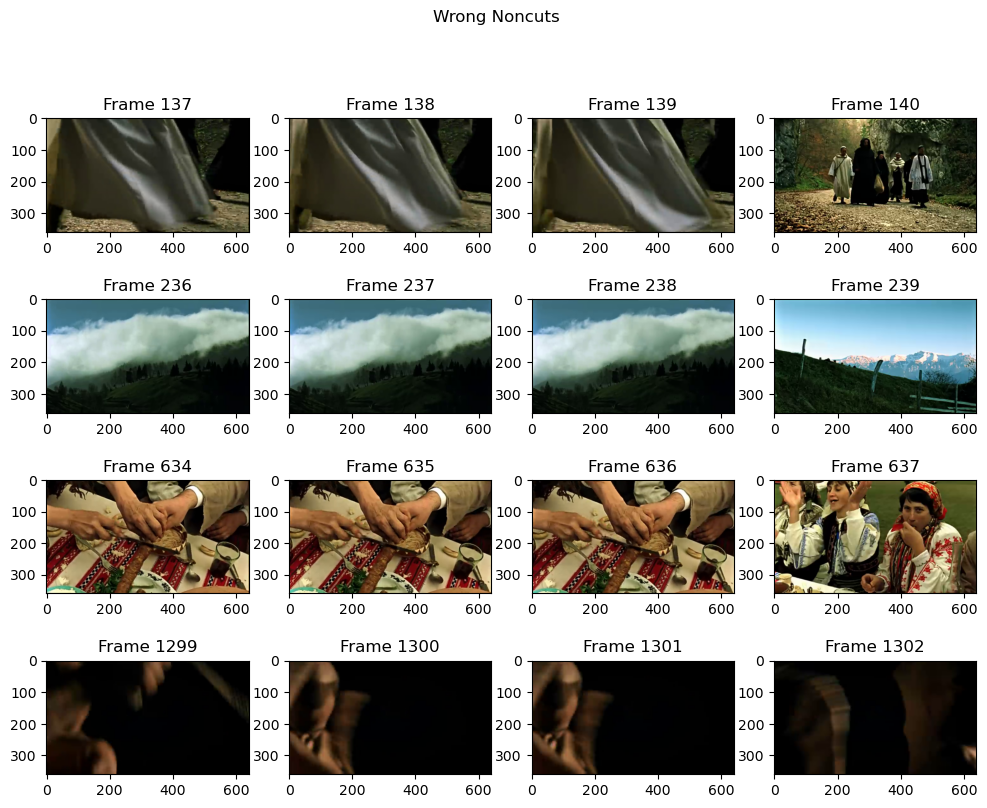

In [23]:
wrong_noncuts = df_frame_info[(df_frame_info['real cut'] == True)&(df_frame_info['predicted cut'] == False)].index.values
chosen_wrong_noncuts = np.sort(np.random.choice(wrong_noncuts, 4, replace=False))


fig, axs = plt.subplots(4, 4)

fig.set_figheight(9)
fig.set_figwidth(12)
fig.suptitle('Wrong Noncuts')

for i in range(4):
    for k in range(4):
        idx = chosen_wrong_noncuts[i] - 2 + k
        frame = video.get_frame(idx)
        axs[i, k].set_title(f'Frame {idx}')
        axs[i, k].imshow(frame)
fig.show()

In the frames 236-298 we see wrong labeling, but not wrong predict.

# Video 2

In [24]:
video = Video('videos/2.mp4')
cuts = get_cuts('timelines/2.kdenlive')

In [25]:
cuts_real = np.zeros(len(video))
cuts_real[cuts] = 1

In [26]:
cuts_predicted = predict_cuts(model, video)

  0%|          | 0/6057 [00:00<?, ?it/s]

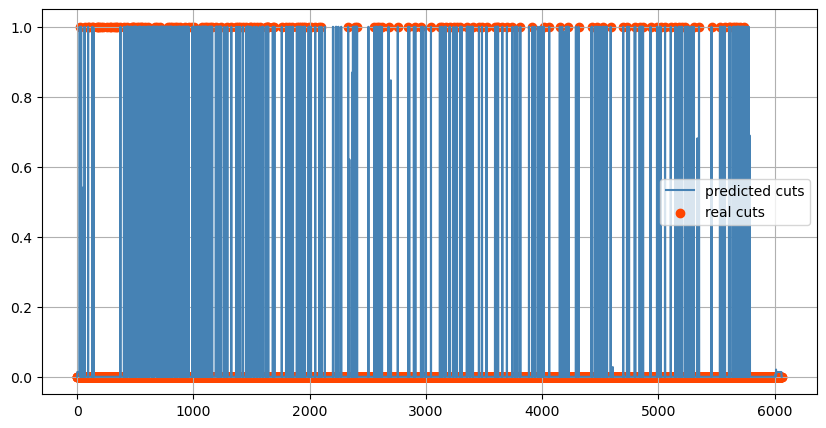

In [27]:
n = len(video)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n), cuts_predicted[:n], color='steelblue', label='predicted cuts')
plt.scatter(np.arange(n), cuts_real[:n], color='orangered', label='real cuts')
plt.grid(True)
plt.legend()
plt.show()

In [28]:
df_frame_info = pd.DataFrame({'real cut' : cuts_real == 1, 
                              'predicted cut' : cuts_predicted > 0.5})
df_frame_info[321:].head(20).transpose()

321    322    323    324    325    326    327    328    329  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 330    331    332    333    334    335    336    337    338  \
real cut       False   True  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 339    340  
real cut       False  False  
predicted cut  False  False

In [29]:
df_square = df_frame_info.copy()
df_square['value'] = df_square.index
df_square = df_square.groupby(['real cut', 'predicted cut'], as_index=False).count()
df_square = pd.DataFrame({'predicted noncut' : df_square[df_square['predicted cut'] == False]['value'].values, 
                          'predicted cut' : df_square[df_square['predicted cut'] == True]['value'].values}, 
                         index=['real noncut', 'real cut'])
print('There are {0} wrong cuts predicted and {1} wrong noncuts.'.format(df_square.loc['real noncut', 'predicted cut'], 
                                                                         df_square.loc['real cut', 'predicted noncut']))
df_square

There are 821 wrong cuts predicted and 14 wrong noncuts.


predicted noncut  predicted cut
real noncut              5091            821
real cut                   14            135

In [30]:
df_square_portion = df_square / df_square.values.sum()
print('There are {0:.2f}% wrong cuts predicted and {1:.2f}% wrong noncuts.'.format(100*float(df_square_portion.loc['real noncut', 'predicted cut']), 
                                                                                  100*float(df_square_portion.loc['real cut', 'predicted noncut'])))
print('But the real cuts portion is just {0:.2f}%'.format(100*float(df_square_portion.loc['real cut', 'predicted cut'])))
df_square_portion

There are 13.55% wrong cuts predicted and 0.23% wrong noncuts.
But the real cuts portion is just 2.23%


predicted noncut  predicted cut
real noncut           0.83996       0.135456
real cut              0.00231       0.022274

/tmp/ipykernel_10321/1817327170.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


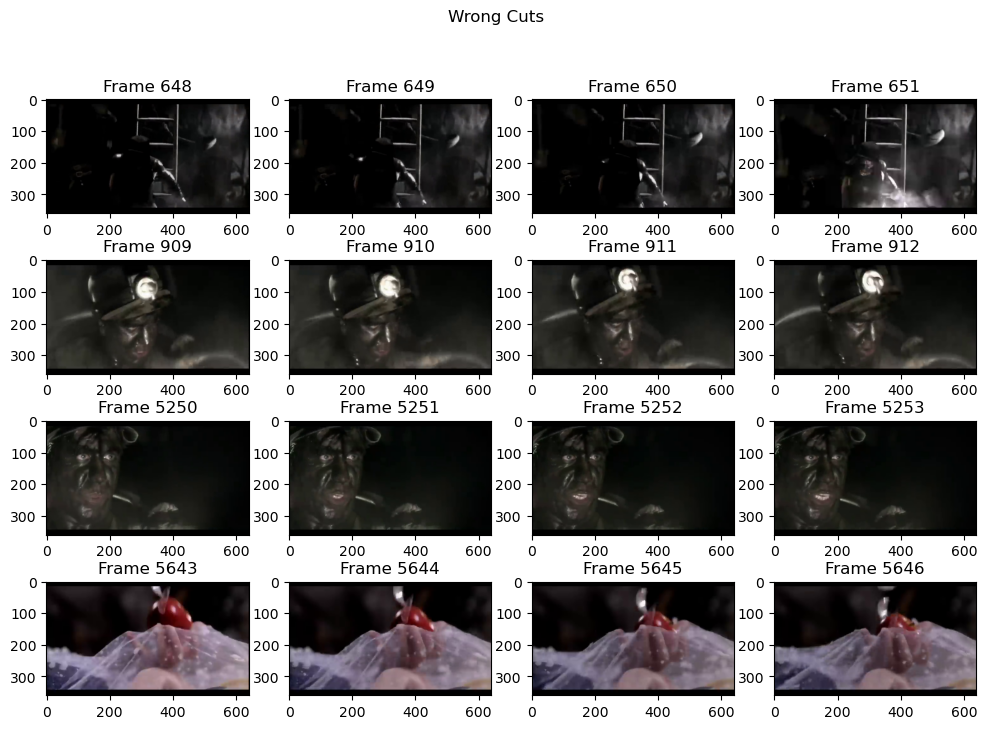

In [31]:
wrong_cuts = df_frame_info[(df_frame_info['real cut'] == False)&(df_frame_info['predicted cut'] == True)].index.values
chosen_wrong_cuts = np.sort(np.random.choice(wrong_cuts, 4, replace=False))


fig, axs = plt.subplots(4, 4)

fig.set_figheight(8)
fig.set_figwidth(12)
fig.suptitle('Wrong Cuts')

for i in range(4):
    for k in range(4):
        idx = chosen_wrong_cuts[i] - 2 + k
        frame = video.get_frame(idx)
        axs[i, k].set_title(f'Frame {idx}')
        axs[i, k].imshow(frame)
fig.show()

In [32]:
wrong_noncuts = df_frame_info[(df_frame_info['real cut'] == True)&(df_frame_info['predicted cut'] == False)].index.values
chosen_wrong_noncuts = np.sort(np.random.choice(wrong_noncuts, 4, replace=False))


fig, axs = plt.subplots(4, 4)

fig.set_figheight(9)
fig.set_figwidth(12)
fig.suptitle('Wrong Noncuts')

for i in range(4):
    for k in range(4):
        idx = chosen_wrong_noncuts[i] - 2 + k
        frame = video.get_frame(idx)
        axs[i, k].set_title(f'Frame {idx}')
        axs[i, k].imshow(frame)
fig.show()

/tmp/ipykernel_10321/4132339254.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


# Video 3

In [33]:
video = Video('videos/3.mp4')
cuts = get_cuts('timelines/3.kdenlive')

In [34]:
cuts_real = np.zeros(len(video))
cuts_real[cuts] = 1

In [35]:
cuts_predicted = predict_cuts(model, video)

  0%|          | 0/3957 [00:00<?, ?it/s]

In [36]:
n = len(video)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n), cuts_predicted[:n], color='steelblue', label='predicted cuts')
plt.scatter(np.arange(n), cuts_real[:n], color='orangered', label='real cuts')
plt.grid(True)
plt.legend()
plt.show()

In [37]:
df_frame_info = pd.DataFrame({'real cut' : cuts_real == 1, 
                              'predicted cut' : cuts_predicted > 0.5})
df_frame_info[456:].head(20).transpose()

456    457    458    459    460    461    462    463    464  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 465    466    467    468    469    470    471    472    473  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 474    475  
real cut       False  False  
predicted cut  False  False

In [38]:
df_square = df_frame_info.copy()
df_square['value'] = df_square.index
df_square = df_square.groupby(['real cut', 'predicted cut'], as_index=False).count()
df_square = pd.DataFrame({'predicted noncut' : df_square[df_square['predicted cut'] == False]['value'].values, 
                          'predicted cut' : df_square[df_square['predicted cut'] == True]['value'].values}, 
                         index=['real noncut', 'real cut'])
print('There are {0} wrong cuts predicted and {1} wrong noncuts.'.format(df_square.loc['real noncut', 'predicted cut'], 
                                                                         df_square.loc['real cut', 'predicted noncut']))
df_square

There are 9 wrong cuts predicted and 6 wrong noncuts.


predicted noncut  predicted cut
real noncut              3930              9
real cut                    6             16

In [39]:
df_square_portion = df_square / df_square.values.sum()
print('There are {0:.2f}% wrong cuts predicted and {1:.2f}% wrong noncuts.'.format(100*float(df_square_portion.loc['real noncut', 'predicted cut']), 
                                                                                  100*float(df_square_portion.loc['real cut', 'predicted noncut'])))
print('But the real cuts portion is just {0:.2f}%'.format(100*float(df_square_portion.loc['real cut', 'predicted cut'])))
df_square_portion

There are 0.23% wrong cuts predicted and 0.15% wrong noncuts.
But the real cuts portion is just 0.40%


predicted noncut  predicted cut
real noncut          0.992174       0.002272
real cut             0.001515       0.004039

/tmp/ipykernel_10321/1528520417.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


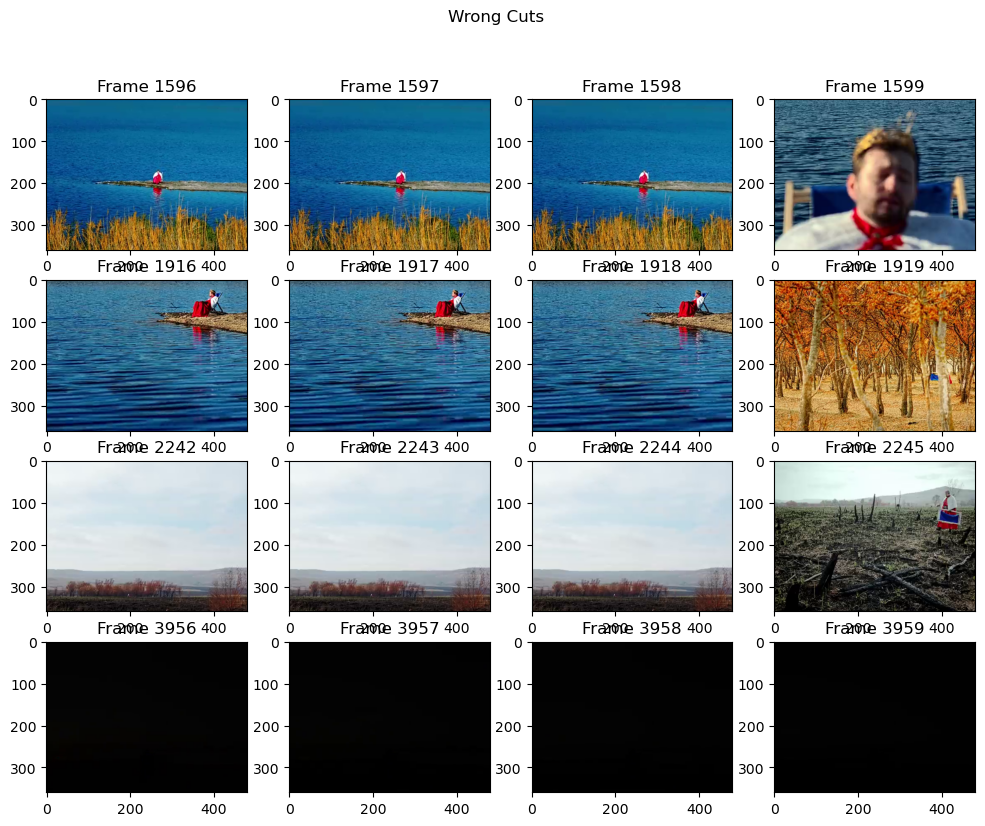

In [40]:
wrong_cuts = df_frame_info[(df_frame_info['real cut'] == False)&(df_frame_info['predicted cut'] == True)].index.values
chosen_wrong_cuts = np.sort(np.random.choice(wrong_cuts, 4, replace=False))


fig, axs = plt.subplots(4, 4)

fig.set_figheight(9)
fig.set_figwidth(12)
fig.suptitle('Wrong Cuts')

for i in range(4):
    for k in range(4):
        idx = chosen_wrong_cuts[i] - 2 + k
        frame = video.get_frame(idx)
        axs[i, k].set_title(f'Frame {idx}')
        axs[i, k].imshow(frame)
fig.show()

/tmp/ipykernel_10321/4132339254.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


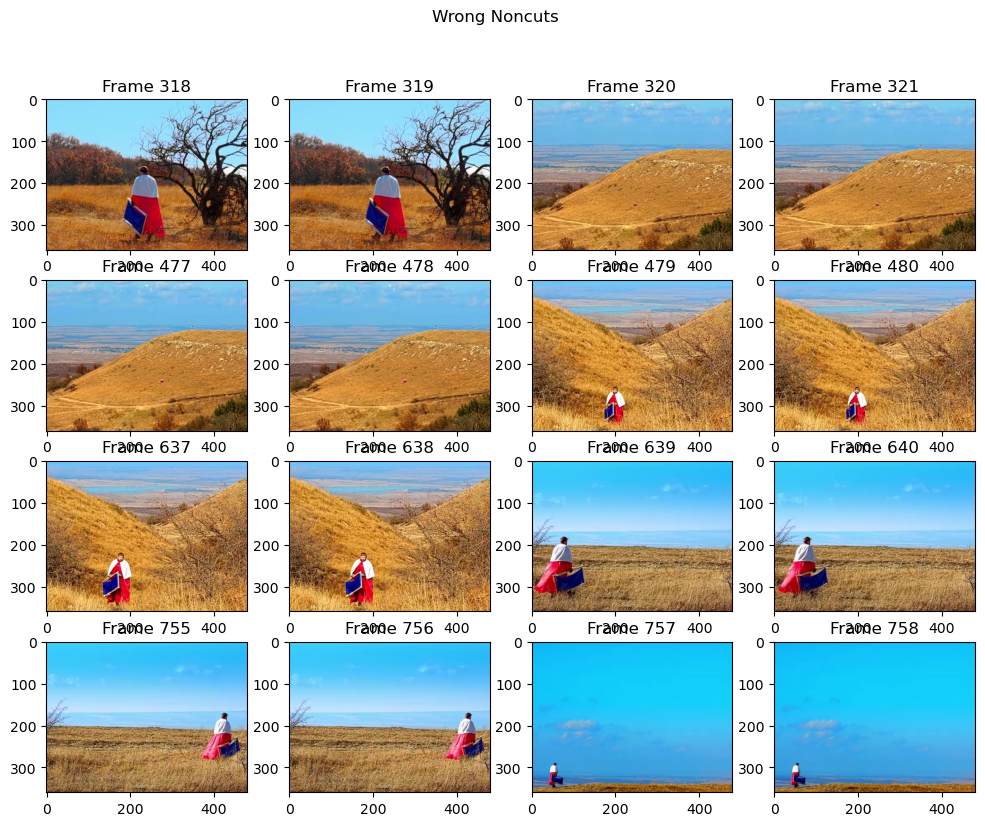

In [41]:
wrong_noncuts = df_frame_info[(df_frame_info['real cut'] == True)&(df_frame_info['predicted cut'] == False)].index.values
chosen_wrong_noncuts = np.sort(np.random.choice(wrong_noncuts, 4, replace=False))


fig, axs = plt.subplots(4, 4)

fig.set_figheight(9)
fig.set_figwidth(12)
fig.suptitle('Wrong Noncuts')

for i in range(4):
    for k in range(4):
        idx = chosen_wrong_noncuts[i] - 2 + k
        frame = video.get_frame(idx)
        axs[i, k].set_title(f'Frame {idx}')
        axs[i, k].imshow(frame)
fig.show()